# Scaler Comparison
In this Notebook the 5 different scalers StandardScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer are compared to analyse differences for selecting the K-Value

## Import of Libs and CSV file

In [184]:
import pandas as pd
from sklearn.metrics import pairwise_distances, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.cluster import KMeans

songs_df = pd.read_csv('Spotify_data/3_spotify_5000_songs.csv')
songs_df.columns = songs_df.columns.str.strip()
songs_cat_df = songs_df.drop(['name','Unnamed: 0', 'artist','type', "id","html"], axis=1).copy()

## Scaling the data

In [186]:
# Create a MinMaxScaler object
scaler = MinMaxScaler().set_output(transform="pandas") # If you want to explore set_output further https://blog.scikit-learn.org/technical/pandas-dataframe-output-for-sklearn-transformer/

# Scale the songs_cat_df DataFrame
songs_cat_minmax = scaler.fit_transform(songs_cat_df)

In [187]:
# Create a StandardScaler object
scaler = StandardScaler().set_output(transform="pandas") # If you want to explore set_output further https://blog.scikit-learn.org/technical/pandas-dataframe-output-for-sklearn-transformer/

# Scale the songs_cat_df DataFrame
songs_cat_standard = scaler.fit_transform(songs_cat_df)

In [188]:
# Create a RobustScaler object
scaler = RobustScaler().set_output(transform="pandas") # If you want to explore set_output further https://blog.scikit-learn.org/technical/pandas-dataframe-output-for-sklearn-transformer/

# Scale the songs_cat_df DataFrame
songs_cat_robust = scaler.fit_transform(songs_cat_df)

In [189]:
# Quantile Transformer
# Number of samples
number_of_samples = songs_cat_df.shape[0]

# Create a QuantileTransformer object
scaler = QuantileTransformer(n_quantiles = number_of_samples).set_output(transform="pandas")

# Transform the foods_df DataFrame
songs_cat_quantile = scaler.fit_transform(songs_cat_df)

In [190]:
# Create a PowerTransformer object
scaler = PowerTransformer().set_output(transform="pandas")

# Transform the songs_cat_df DataFrame
songs_cat_power = scaler.fit_transform(songs_cat_df)

## Inertia Scores of each scaler

In [192]:
# initialize final data frame:
method_list = ['MinMax', 'Standard', 'Robust', 'Quantile', 'Power']
scaled_dfs_list = [songs_cat_minmax, songs_cat_standard, songs_cat_robust, songs_cat_quantile, songs_cat_power] # list of all data frames created with the different methods
# Create an empty list to store the inertia scores
inertia_list = []
column_counter = 0

# Decide on a random_state to use
seed = 123

# Set the maximum number of clusters to try
max_k = 100

# Create a list of cluster counts
k_values = list(range(1, max_k + 1))

for df in scaled_dfs_list:
    
    # Iterate over the range of cluster numbers
    for i in range(1, max_k + 1):

        # Create a KMeans object with the specified number of clusters
        myKMeans = KMeans(n_clusters = i,
                          n_init = "auto",
                          random_state = seed)
    
        # Fit the KMeans model to the scaled data
        myKMeans.fit(df)
    
        # Append the inertia score to the list
        inertia_list.append(myKMeans.inertia_)

inertia_method_df = pd.DataFrame({
    'k': k_values * len(method_list),
    'inertia': inertia_list,
    'method': [method for method in method_list for _ in range(max_k)]
})
inertia_method_df

,k,inertia,method
0,1,4619.353396,MinMax
1,2,3691.957970,MinMax
2,3,2645.051040,MinMax
3,4,2229.530989,MinMax
4,5,2029.710487,MinMax
...,...,...,...
495,96,18860.920898,Power
496,97,18808.034871,Power
497,98,18750.181016,Power
498,99,18729.158895,Power


## K-Value for each scaler using KneeLocator
The requirment for this case study is to have 50 to 250 songs per playlist. Considering about 5000 songs in the dataset the K-Value should lie somewhere between 20 to 100.

In [194]:
from kneed import KneeLocator

inertia_MinMax = inertia_method_df.loc[20:99,'inertia'] # K-Values from 20 to 100 for MinMaxScaler
inertia_Standard = inertia_method_df.loc[120:199,'inertia'] # K-Values from 20 to 100 for StandardScaler
inertia_Robust = inertia_method_df.loc[220:299,'inertia'] # K-Values from 20 to 100 for RobustScaler
inertia_Quantile = inertia_method_df.loc[320:399,'inertia'] # K-Values from 20 to 100 for QuantileTransformer
inertia_Power = inertia_method_df.loc[420:499,'inertia'] # K-Values from 20 to 100 for PowerTransformer

inertia_lists = [inertia_MinMax, inertia_Standard, inertia_Robust, inertia_Quantile, inertia_Power]
kl_list = []

for inertia_list in inertia_lists:
    
    k_range = range(21, max_k + 1)
    # Use KneeLocator to find the elbow point
    kl = KneeLocator(
        k_range, inertia_list, curve='convex', direction='decreasing'
    )
    kl_list.append(kl.elbow)

## Visualization of inertia score and K_Value determined by KneeLocator for each scaling method

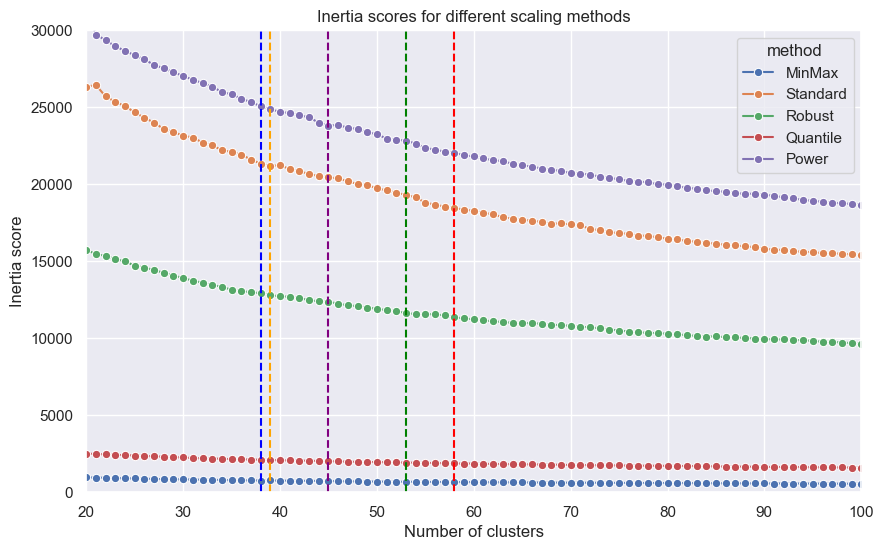

In [196]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(10, 6))
sns.lineplot(data=inertia_method_df, x='k', y='inertia', hue='method', marker='o')

plt.title('Inertia scores for different scaling methods')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia score')
plt.ylim(0,30000)
plt.xlim(20, 100)

color_list = ['blue','orange', 'green', 'red', 'purple']
color_counter = 0
for kl in kl_list:
    plt.axvline(kl, color=color_list[color_counter], linestyle='--', label=f'Elbow at k={kl}')
    color_counter += 1
plt.show()

## Silhouette score for each scaler

In [198]:
# initialize final data frame:
method_list = ['MinMax', 'Standard', 'Robust', 'Quantile', 'Power']
scaled_dfs_list = [songs_cat_minmax, songs_cat_standard, songs_cat_robust, songs_cat_quantile, songs_cat_power] # list of all data frames created with the different methods
# Create an empty list to store the silhouette scores
sil_scores = []

# Decide on a random_state to use
seed = 123

# Set the maximum number of clusters to try
max_k = 100

# Create a list of cluster counts
k_values = list(range(2, max_k))

for df in scaled_dfs_list:
    
    # Iterate over the range of cluster numbers
    for j in range(2, max_k):

        # Create a KMeans object with the specified number of clusters
        kmeans = KMeans(n_clusters = j,
                        n_init = "auto",
                        random_state = seed)
    
        # Fit the KMeans model to the scaled data
        kmeans.fit(df)
    
        # Get the cluster labels
        labels = kmeans.labels_
    
        # Calculate the silhouette score
        score = silhouette_score(df, labels)
    
        # Append the silhouette score to the list
        sil_scores.append(score)

sil_method_df = pd.DataFrame({
    'k': k_values * len(method_list),
    'sil_score': sil_scores,
    'method': [method for method in method_list for _ in range(2,max_k)]
})

## Visualization of silhouette score and K-Value determined by Kneelocator for each scaling method

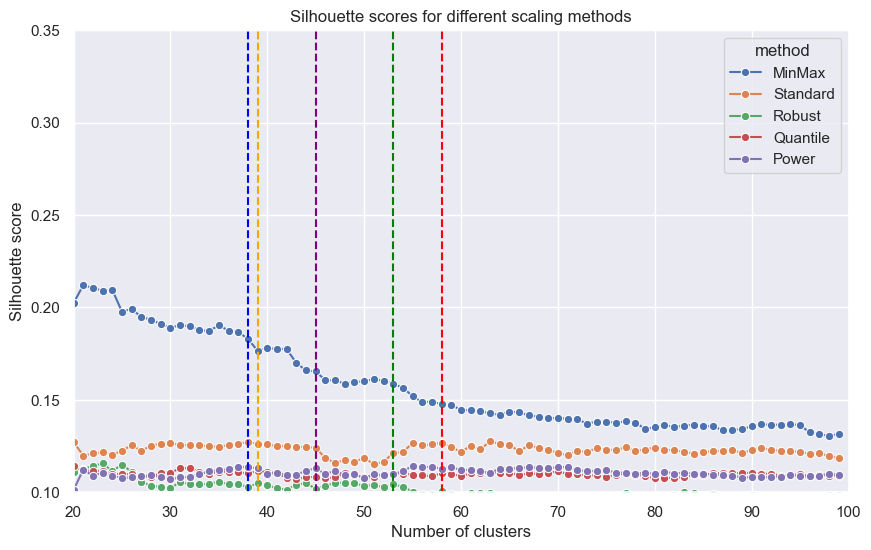

In [200]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(10, 6))
sns.lineplot(data=sil_method_df, x='k', y='sil_score', hue='method', marker='o')

plt.title('Silhouette scores for different scaling methods')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.ylim(0.1, 0.35)
plt.xlim(20, 100)
color_counter = 0
for kl in kl_list:
    plt.axvline(kl, color=color_list[color_counter], linestyle='--', label=f'Elbow at k={kl}')
    color_counter += 1

plt.show()

## Creating playlists with K-means

In [202]:
# initialize the model
random_seed = 123
my_full_kmeans = KMeans(n_clusters = 45, n_init = "auto", random_state = seed) # we'll explore how to choose the number of clusters in a later notebook

# fit the model to the data
my_full_kmeans.fit(songs_cat_power)

# obtain the cluster output
category = my_full_kmeans.labels_

# attach the cluster output to our original DataFrame
songs_df["category"] = category

songs_per_playlist = songs_df['category'].value_counts()

## Visualization of songs per playlist
The requirement in this case study was to create playlists with a lenght of 50 to 250 songs. In this visualization you can see that with the selected scaling method, the amount of PCs and number of clusters, K_means is performing pretty well in creating playlists within the requested size. Only one playlist is outside of the requested playlist length.

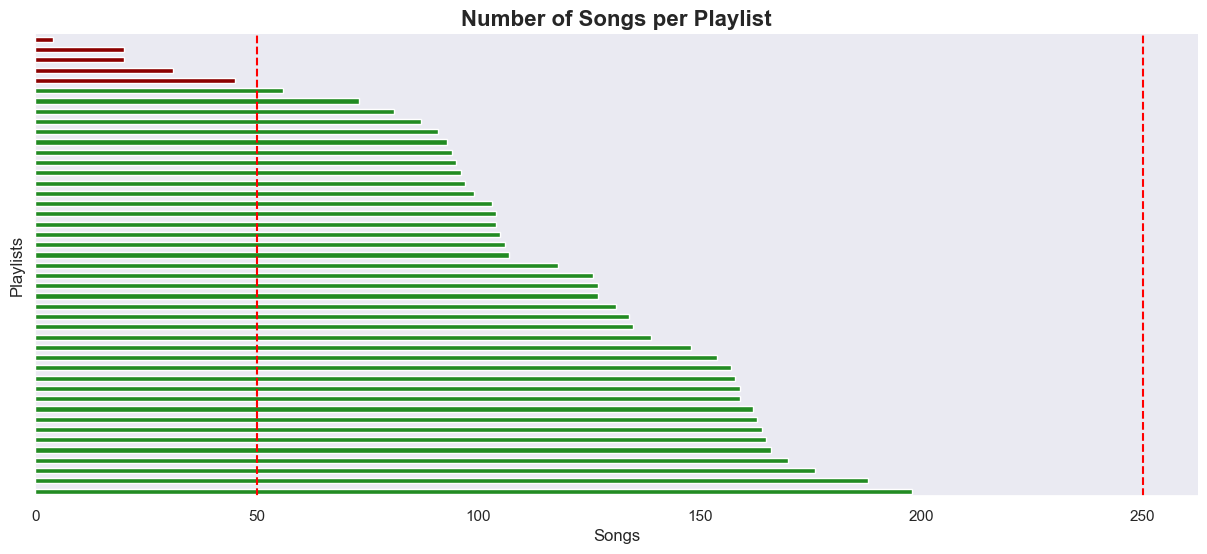

In [204]:
import matplotlib.pyplot as plt
#sns.set_theme(style='white')
# Plot
threshold = 50
colors = ['darkred' if value < threshold else 'forestgreen' for value in songs_per_playlist]
ax = songs_per_playlist.plot(kind='barh', figsize=(15, 6), color=colors)

# Hide y-axis tick labels (categories)
ax.set_yticklabels([])  # This hides the category labels
ax.tick_params(axis='y', which='both', length=0)  # Hide tick marks

# Keep axis label/title
ax.set_ylabel("Playlists")  # Your axis title
ax.set_xlabel("Songs")
ax.set_title("Number of Songs per Playlist", fontsize=16, fontweight='bold')
ax.grid(False)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# add vertical lines for given range of songs per playlist:
plt.axvline(50, color="red", linestyle='--')
plt.axvline(250, color="red", linestyle='--')

# Optional: Adjust thickness of bars (increase height per bar)
#bar_count = len(songs_per_playlist)
#ax.figure.set_size_inches(12, bar_count * 0.6)  # Increase height per bar

# Save the chart as a PNG file at the specified path
# plt.savefig(r"C:\Users\wulko\OneDrive\Dokumente\Wohnung Denzlingen\Data Science Boot camp\ML\unsupervised ML\Songs_per_Playlist", dpi=300, bbox_inches='tight')

#plt.tight_layout()
plt.show()

## Visualization of feature distribution with different scalers
The code in the next cell will ask you to select one of the mentioned music features. Once you decided for a feature it will generate a Histogram with KDE for each scaling method for the chosen feature.

Here is a list of all features: ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']


Select a feature: liveness


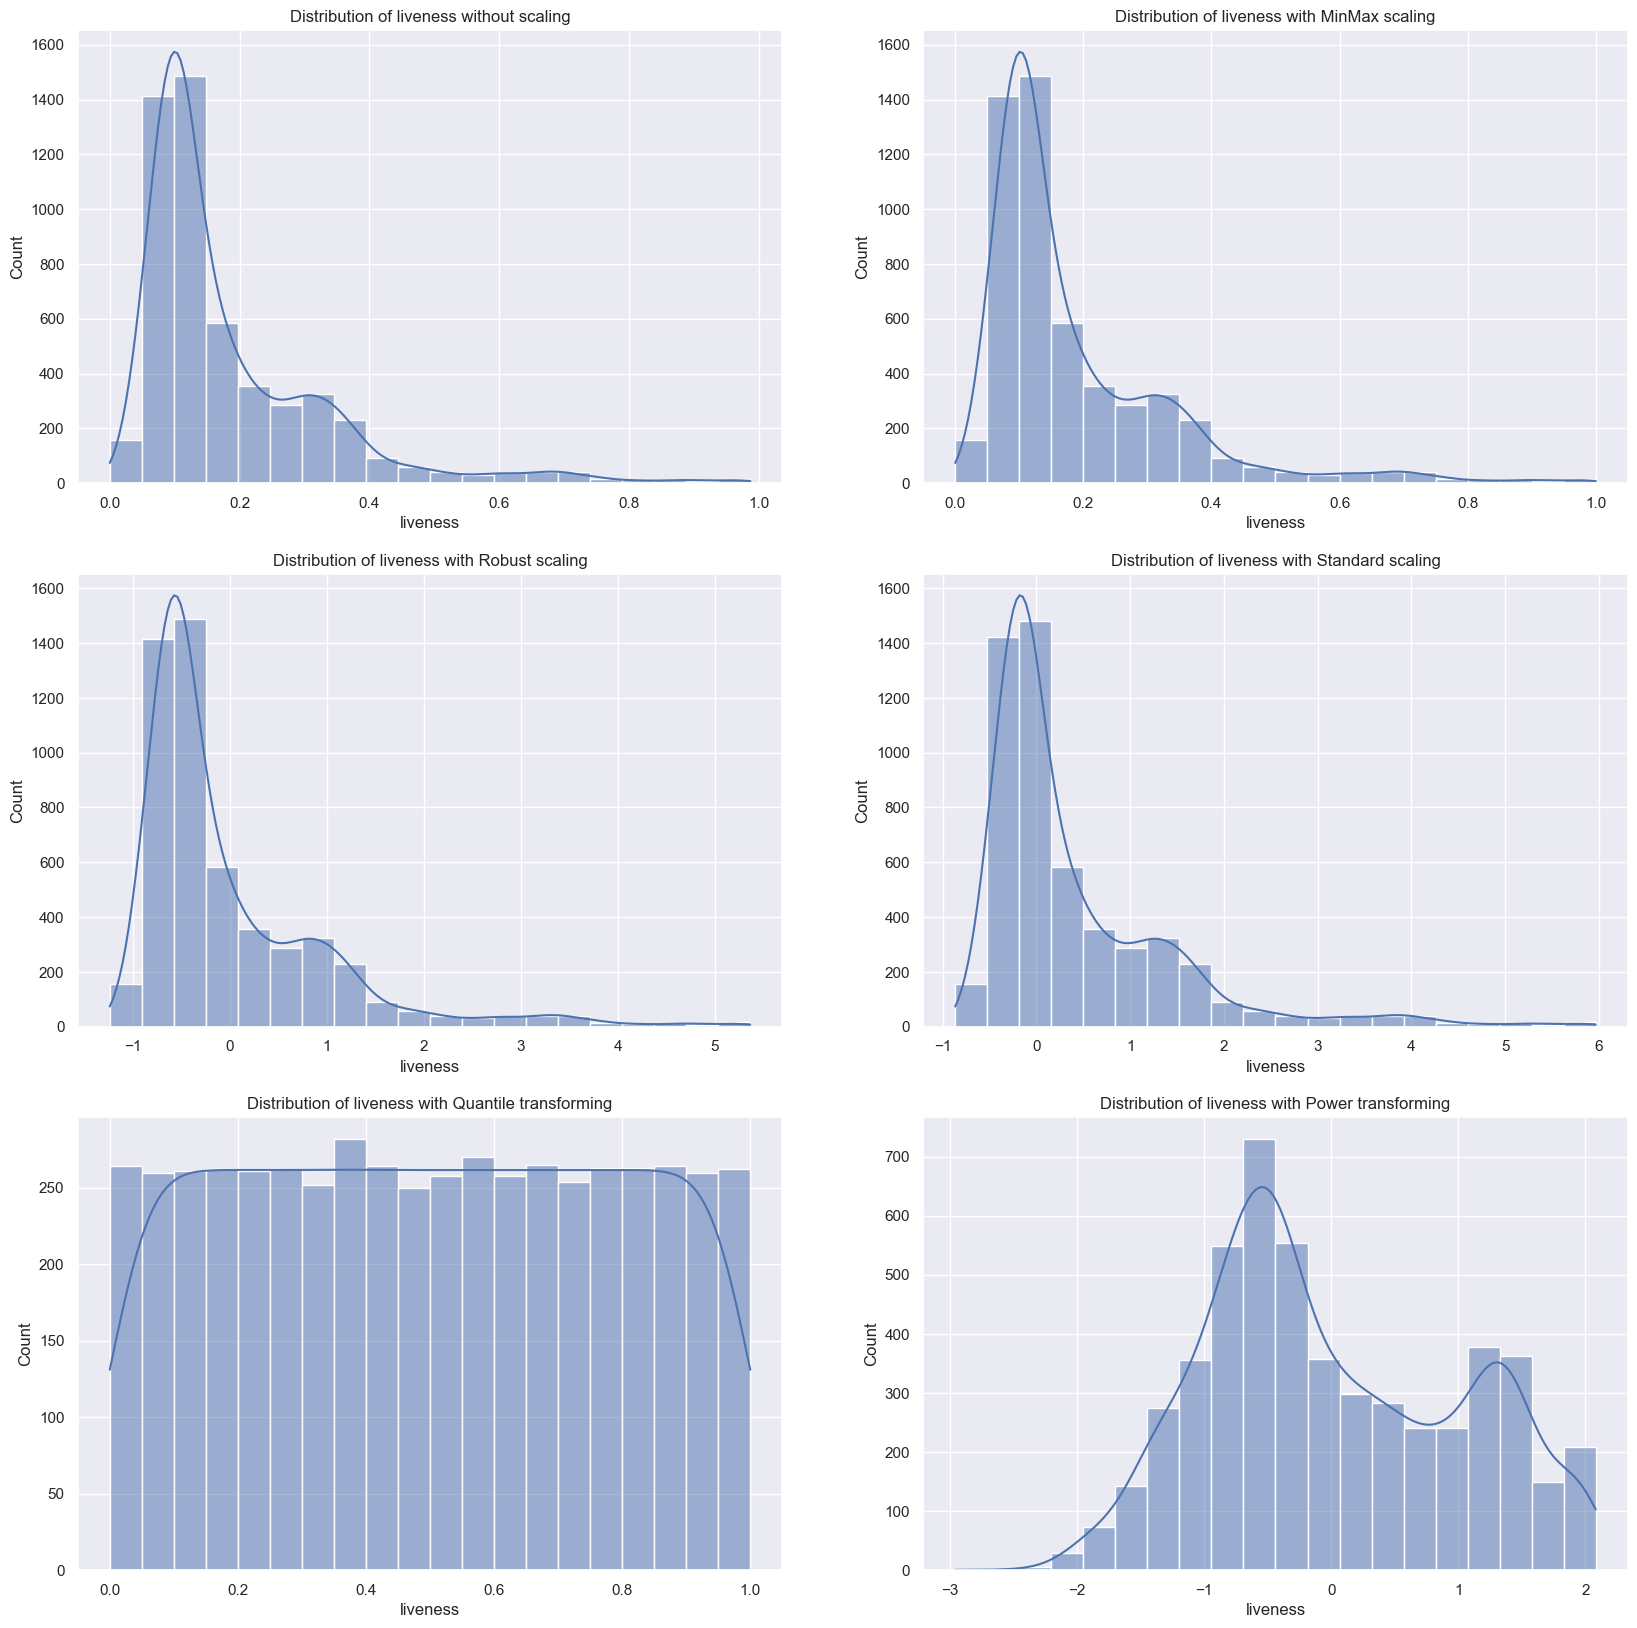

In [206]:
# get distribution of a selected feature by method
features_list = songs_cat_df.columns.tolist()
print(f'Here is a list of all features: {features_list}')
feature = str(input("Select a feature:"))

fig, ax = plt.subplots(3, 2, figsize=(20, 20))

sns.histplot(data=songs_cat_df.loc[:,feature], bins=20, kde=True, ax=ax[0, 0]);
sns.histplot(data=songs_cat_minmax.loc[:,feature], bins=20, kde=True, ax=ax[0, 1]);
sns.histplot(data=songs_cat_standard.loc[:,feature], bins=20, kde=True, ax=ax[1, 0]);
sns.histplot(data=songs_cat_robust.loc[:,feature], bins=20, kde=True, ax=ax[1, 1]);
sns.histplot(data=songs_cat_quantile.loc[:,feature], bins=20, kde=True, ax=ax[2, 0]);
sns.histplot(data=songs_cat_power.loc[:,feature], bins=20, kde=True, ax=ax[2, 1]);

ax[0, 0].set_title(f'Distribution of {feature} without scaling')
ax[0, 1].set_title(f'Distribution of {feature} with MinMax scaling')
ax[1, 0].set_title(f'Distribution of {feature} with Robust scaling')
ax[1, 1].set_title(f'Distribution of {feature} with Standard scaling')
ax[2, 0].set_title(f'Distribution of {feature} with Quantile transforming')
ax[2, 1].set_title(f'Distribution of {feature} with Power transforming')

plt.show()